<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# импортирование библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# чтение файла
# сортировка индексов таблицы
data = pd.read_csv('/datasets/taxi.csv', parse_dates = [0], index_col = [0])
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# ресемплирование по одному часу
# суммирование количества заказов
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Вывод

Проведено ресемплирование по одному часу и суммирование количества заказов.

## Анализ

In [5]:
# разложение временного ряда на сезонность,
# тренд и остаток
decomposed = seasonal_decompose(data)

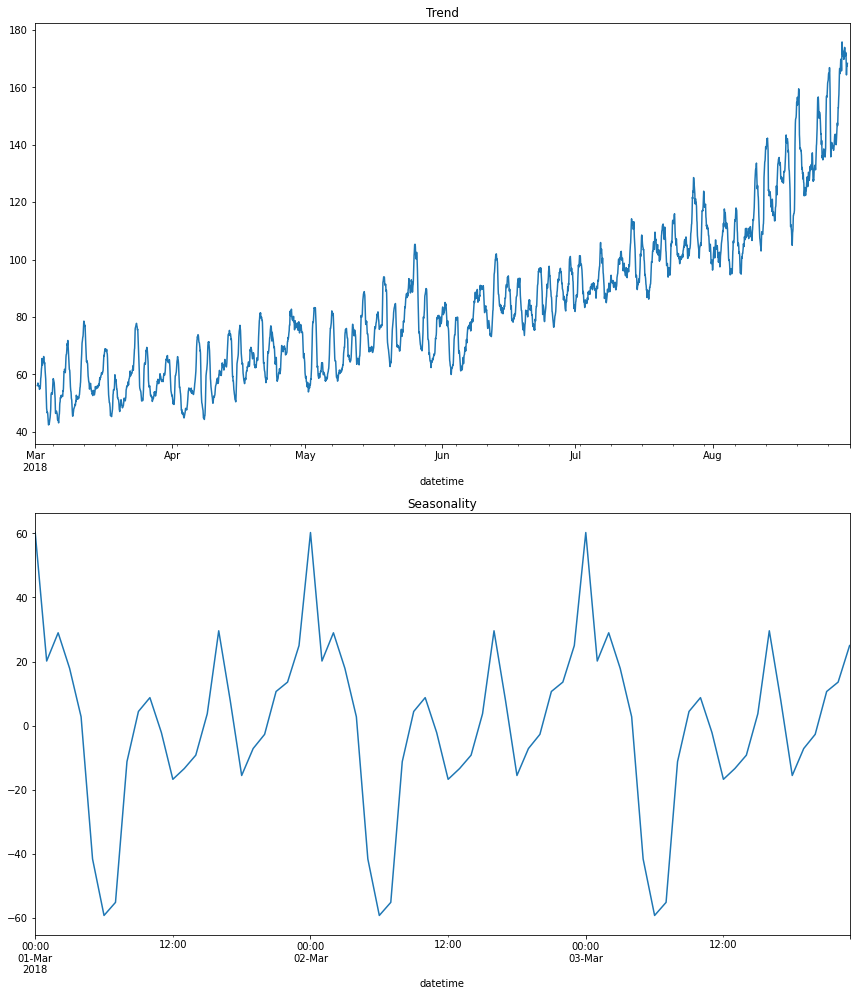

In [6]:
# построение графиков тренда и сезонности
plt.figure(figsize=(12,20))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-03'].plot(ax=plt.gca())
plt.title('Seasonality')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

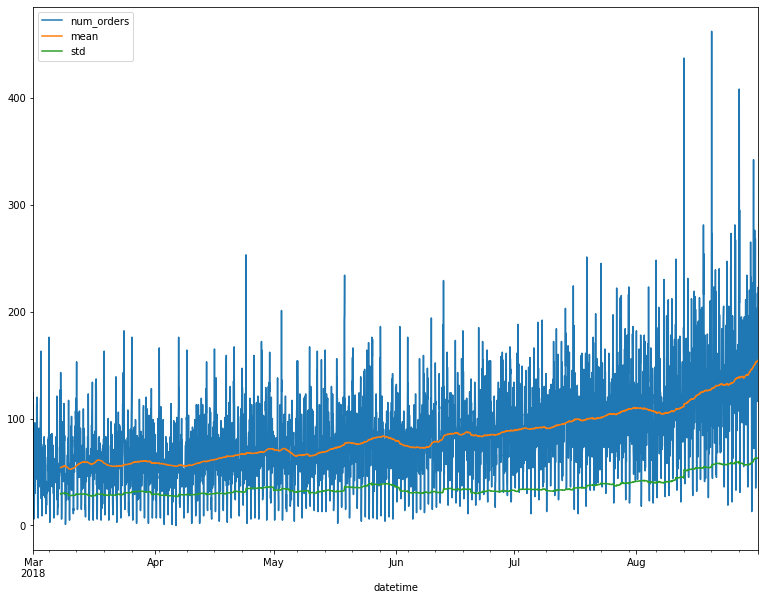

In [7]:
data['mean'] = data['num_orders'].rolling(24*7).mean()
data['std'] = data['num_orders'].rolling(24*7).std()
data.plot(figsize = (13,10)) 

### Вывод

- Выполнено разложение временного ряда на сезонность, тренд и остаток. Проанализированы первые 2 параметра:
    - Тренд связан с временем года. Спрос на такси увеличивается к отпускному сезону, с марта по август он постепенно возрастает.
    - Сезонность связана с временем суток. С раннего утра до полуночи спрос растёт, затем постепенно ослабевает.
- Проведён анализ скользящего отклонения. Ряд приведён к стационарному виду.

## Обучение

In [9]:
data_new = data.copy(deep=True)
data_new.head()

,num_orders,mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN


In [10]:
# создание признаков для горизонта прогнозирования в одиг шаг
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    

make_features(data_new, 25, 24)

In [11]:
data_new = data_new.drop(['mean','std'], axis=1)

In [12]:
data_new.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
# деление исходного набора данных на две выборки: обучающую и тестовую
# под обучающую отвела 90%, под тестовую - 10%
train, test = train_test_split(data_new,
                               shuffle=False,
                               test_size = 0.1)

In [94]:
# удаление пропусков 
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [95]:
model_1 = LinearRegression()
model_1.fit(features_train, target_train)
pred_train_1 = model_1.predict(features_train)
rmse_train_1 = mean_squared_error(target_train, pred_train_1)**0.5
print('Значение RSME:', rmse_train_1)

Значение RSME: 25.7759432278792


In [98]:
best_model_2 = None
best_result_2 = 48
best_est_2 = 0
best_depth_2 = 0 

for est in range(10,51,5):
    for depth in range(1,8):
        model_2 = RandomForestRegressor(random_state = 12345,
                                        n_estimators = est,
                                        max_depth = depth)
        result_2 = cross_val_score(model_2, features_train, target_train, 
                                   cv = TimeSeriesSplit(n_splits = 5),
                                   scoring = 'neg_mean_squared_error')
        result_2 = np.mean(np.sqrt(np.abs(result_2)))
        
        if result_2 < best_result_2:
            best_model_2 = model_2
            best_result_2 = result_2
            best_est_2 = est
            best_depth_2 = depth

print('Лучшее значение RSME:', best_result_2, 
      'Количество деревьев:', best_est_2,
      'Глубина дерева:', best_depth_2)

Лучшее значение RSME: 26.814530362718074 Количество деревьев: 50 Глубина дерева: 7


In [100]:
best_model_3 = None
best_result_3 = 48
best_est_3 = 0
best_depth_3 = 0 

for est in range(10,51,5):
    for depth in range(1,8):
        model_3 = LGBMRegressor(n_estimators = est, 
                                max_depth = depth)
        result_3 = cross_val_score(model_3, features_train, target_train, 
                                   cv = TimeSeriesSplit(n_splits = 5),
                                   scoring = 'neg_mean_squared_error')
        result_3 = np.mean(np.sqrt(np.abs(result_3)))
        
        if result_3 < best_result_3:
            best_model_3 = model_3
            best_result_3 = result_3
            best_est_3 = est
            best_depth_3 = depth

print('Лучшее значение RSME:', best_result_3, 
      'Количество деревьев:', best_est_3,
      'Глубина дерева:', best_depth_3)

Лучшее значение RSME: 25.647619375109734 Количество деревьев: 50 Глубина дерева: 7


## Тестирование

In [101]:
pred_test_1 = model_1.predict(features_test)
rmse_test_1 = mean_squared_error(target_test, pred_test_1)**0.5
predictions_1 = list(pred_test_1)
print('Значение RSME:', rmse_test_1)

Значение RSME: 45.671435011292836


Text(0.5, 1.0, 'Predictions')

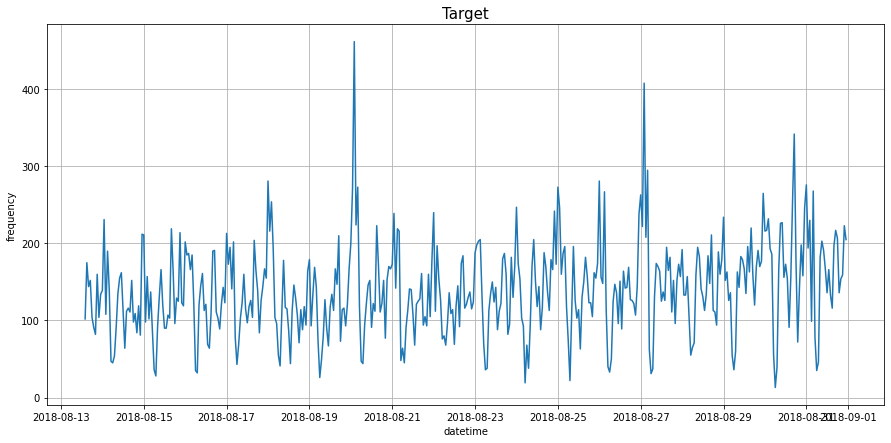

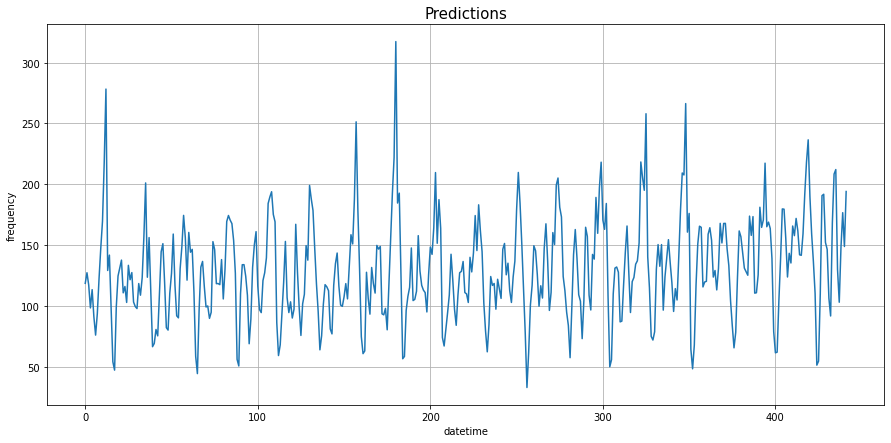

In [102]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(target_test, label='test')
plt.xlabel('datetime')
plt.ylabel('frequency')
plt.title('Target', fontsize=15)

plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(predictions_1, label='predictions')
plt.xlabel('datetime')
plt.ylabel('frequency')
plt.title('Predictions', fontsize=15)

In [103]:
best_model_2.fit(features_train, target_train)
pred_test_2 = best_model_2.predict(features_test)
rmse_test_2 = mean_squared_error(target_test, pred_test_2)**0.5
predictions_2 = list(pred_test_2)
print('Значение RSME:', rmse_test_2)

Значение RSME: 45.60260513374894


Text(0.5, 1.0, 'Predictions')

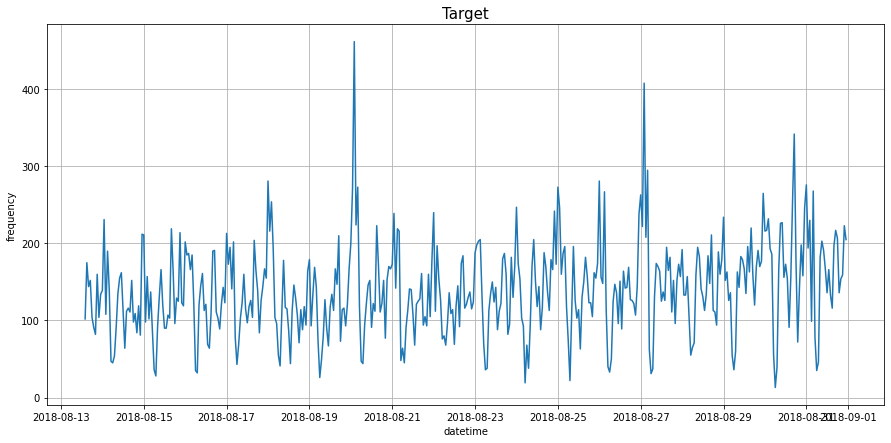

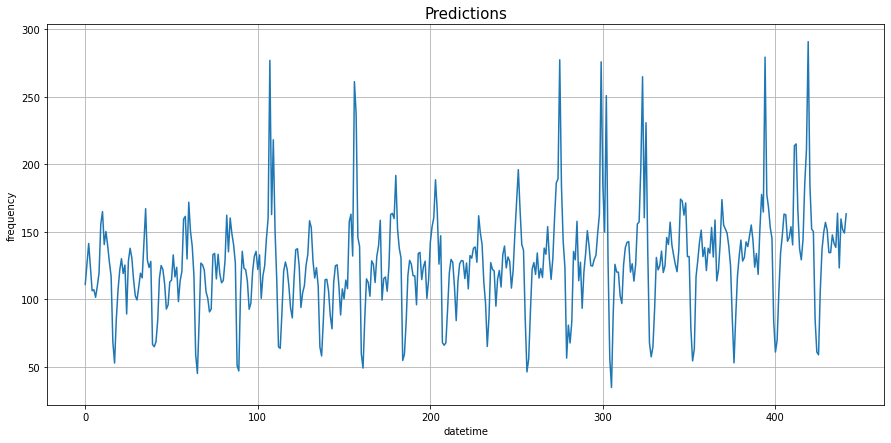

In [104]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(target_test, label='test')
plt.xlabel('datetime')
plt.ylabel('frequency')
plt.title('Target', fontsize=15)

plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(predictions_2, label='predictions')
plt.xlabel('datetime')
plt.ylabel('frequency')
plt.title('Predictions', fontsize=15)

In [105]:
best_model_3.fit(features_train, target_train)
pred_test_3 = best_model_3.predict(features_test)
rmse_test_3 = mean_squared_error(target_test, pred_test_3)**0.5
predictions_3 = list(pred_test_3)
print('Значение RSME:', rmse_test_3)

Значение RSME: 44.255081542403936


Text(0.5, 1.0, 'Predictions')

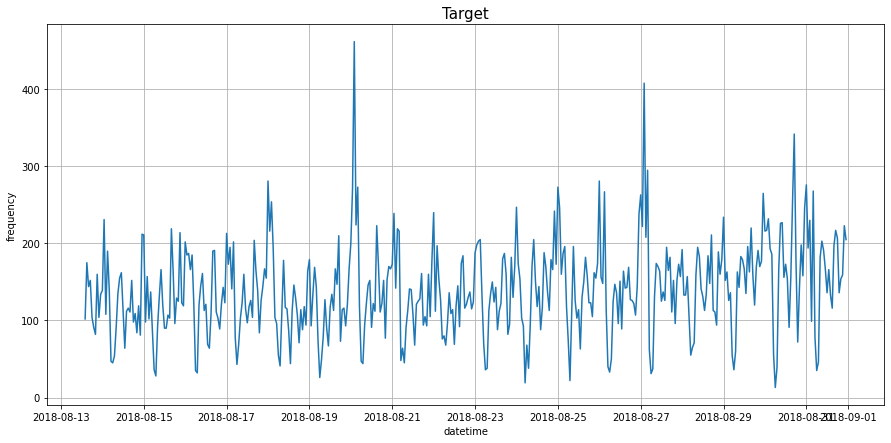

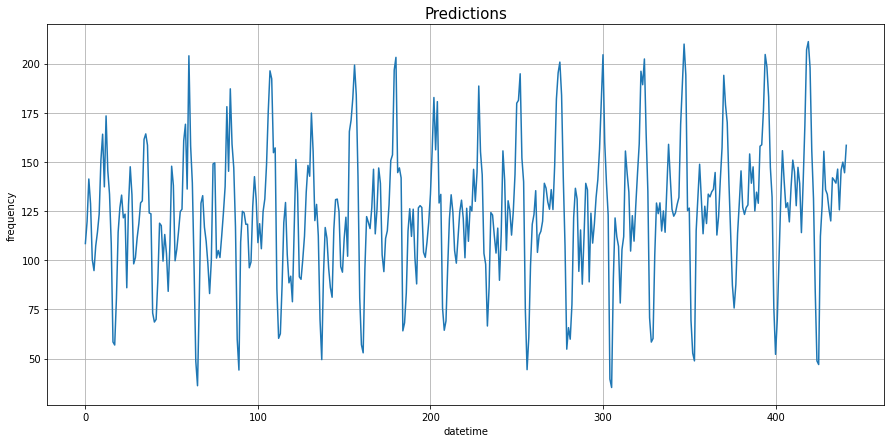

In [106]:
plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(target_test, label='test')
plt.xlabel('datetime')
plt.ylabel('frequency')
plt.title('Target', fontsize=15)

plt.figure(figsize=(15, 7))
plt.grid()
plt.plot(predictions_3, label='predictions')
plt.xlabel('datetime')
plt.ylabel('frequency')
plt.title('Predictions', fontsize=15)

## Вывод

Была построена модель для спрогнозирования количества заказов такси на следующий час. Все значения метрики качества приведены к нужному значению. Лучший результат метрики качества показала модель LGBMRegressor.